# plot zonal sections

In [3]:
%matplotlib inline
from config_calc import *
from glob import glob
import matplotlib.pyplot as plt
plt.rcParams['mathtext.default']='regular'
import matplotlib.colors as colors

import cmocean
import colorbrewer
import plot_tools

from config_calc import *
from proc_cesm_le import open_ens
                                     
varlist = ['O2','AOU'] #,'TEMP']
op = 'ann_dft_za'

#-- read datasets
tr85 = open_ens('tr85',op,varlist)
tr45 = open_ens('tr85',op,varlist)


#-- compute derived
v = 'O2sat'
tr85[v] = tr85['AOU'] + tr85['O2']
tr45[v] = tr45['AOU'] + tr45['O2']
varlist.append(v)  

tr85a = tr85.mean(dim='ens')
tr45a = tr45.mean(dim='ens')

tr85a


/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, time: 182, z_t: 60)
Coordinates:
  * time         (time) float64 7.01e+05 7.01e+05 7.014e+05 7.017e+05 ...
  * lat_t        (lat_t) float32 -79.2205 -78.6863 -78.1521 -77.6179 ...
  * lat_t_edges  (lat_t_edges) float32 -79.4871 -78.9529 -78.4187 -77.8844 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 3.5e+03 4.5e+03 5.5e+03 ...
Dimensions without coordinates: basins
Data variables:
    O2           (time, basins, z_t, lat_t) float64 nan nan 344.2 341.4 ...
    AOU          (time, basins, z_t, lat_t) float64 nan nan 28.65 31.9 35.52 ...
    O2sat        (time, basins, z_t, lat_t) float64 nan nan 372.9 373.3 ...

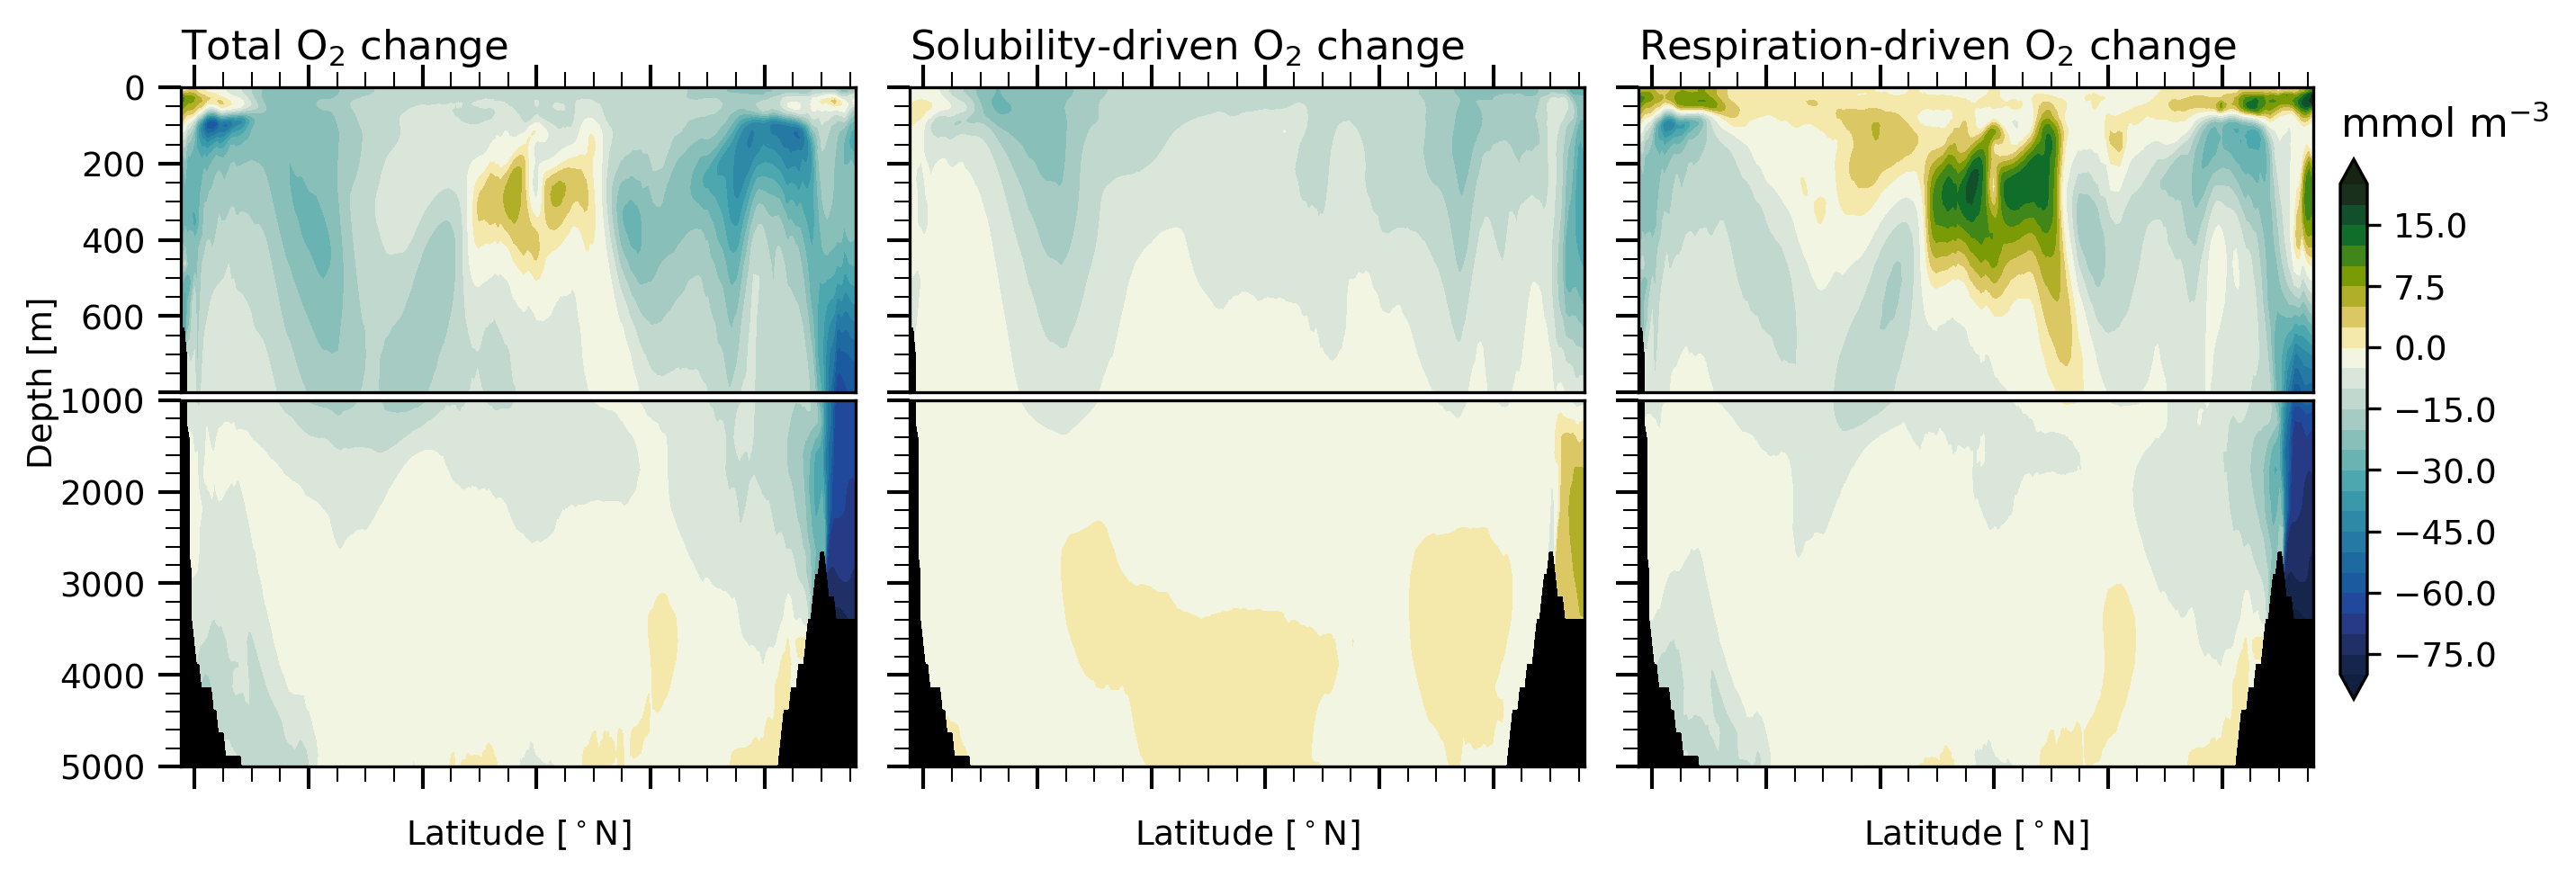

In [8]:
reload(plot_tools)
import matplotlib.gridspec as gridspec

plot_name = os.path.join(diro['fig'],'global-zonal-mean-O2-AOU-O2sat.pdf')

lat = tr85a['lat_t']
depth = tr85a['z_t']/100.

fig = plt.figure(dpi=300,figsize=(10,3.33333))

gs = gridspec.GridSpec(1,3)

levels = np.concatenate((np.arange(-80.,0.,5.),np.arange(0.,22.5,2.5)))
norm = plot_tools.MidPointNorm(midpoint=0.)
contour_specs = {'levels':levels,'cmap':cmocean.cm.delta,'norm':norm,'extend':'both'}

#field = np.zeros((len(depth),len(lat)))
obj = {}
for i,v in enumerate(['O2','O2sat','AOU']):
    baseline = tr85a[v][0:20,:].mean(dim='time')
    field = tr85a[v][-1,0,:,:] - baseline[0,:,:]

    if v == 'AOU':
        field = -1.*field

    obj[v] = plot_tools.canvas_full_depth_section(lat,depth,field,
                                       fig = fig,
                                       gridspec_spec = gs,
                                       gridspec_index = i,
                                       contour_specs = contour_specs,
                                       xlim = [-78,70])

    if i > 0:
        [ax.set_yticklabels([]) for ax in obj[v]['ax']]
        [ax.set_ylabel('') for ax in obj[v]['ax']]

gs.update(left=0.1, right=0.89, wspace=0.08)

cbaxes = fig.add_axes([0.9, 0.2, 0.01, 0.6])
cb = fig.colorbar(obj['O2']['cf'][0], cax=cbaxes)
cbaxes.set_title('mmol m$^{-3}$',loc='left')

obj['O2']['ax'][0].set_title('Total O$_2$ change',loc='left',y=1.02)
obj['O2sat']['ax'][0].set_title('Solubility-driven O$_2$ change',loc='left',y=1.02)
obj['AOU']['ax'][0].set_title('Respiration-driven O$_2$ change',loc='left',y=1.02)
plt.savefig(plot_name,dpi=300,bbox_inches='tight')